In [54]:
# imports
import math
import pandas as pd
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 20)

import numpy as np
import gc

#import catboost ## thanks to yandex ! :) 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
#from tqdm import tqdm_notebook

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline 
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable
# info about itertools.product: 
# https://pythonworld.ru/moduli/modul-itertools.html
# https://docs.python.org/2/library/itertools.html
from itertools import product
from xgboost import XGBClassifier
import xgboost as xgb

In [2]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

# Data Preparation

Merge data per month:

In [4]:
eff_train = pd.read_csv('data/eff_train/eff_train1.csv', sep=';')
for x in range(2,11):
    eff_train_new = pd.read_csv('data/eff_train/eff_train{}.csv'.format(x), sep=';')
    eff_train = pd.concat([eff_train, eff_train_new])
eff_train = eff_train.rename(columns = {' timestamp':'timestamp', ' value':'value', ' quality':'quality'})
eff_train.head(2)

,tag,timestamp,value,quality
0,Efficiency,01.10.2016 0:00,16137.70,Good
1,Efficiency,01.10.2016 0:00,16060.55,Good


In [5]:
eff_test1 = pd.read_csv('data/eff_test/eff_test1.csv', sep=';')
eff_test2 = pd.read_csv('data/eff_test/eff_test2.csv', sep=';')
eff_test = pd.concat([eff_test1, eff_test2])
eff_test = eff_test.rename(columns = {' timestamp':'timestamp', ' value':'value', ' quality':'quality'})
eff_test.head(2)

,tag,timestamp,value,quality
0,Efficiency,01.08.2017 0:00,16836.91,Good
1,Efficiency,01.08.2017 0:00,17145.51,Good


In [6]:
energy_train = pd.read_csv('data/energy_cons_train/Energy_cons_train1.csv', sep=';')
for x in range(2,11):
    energy_train_new = pd.read_csv('data/energy_cons_train/Energy_cons_train{}.csv'.format(x), sep=';')
    energy_train = pd.concat([energy_train, energy_train_new])
energy_train = energy_train.rename(columns = { ' timestamp':'timestamp', ' value':'value', ' quality':'quality'})
energy_train.head(2)

,tag,timestamp,value,quality
0,Energy_cons,01.10.2016 0:01,20.347508,Good
1,Energy_cons,01.10.2016 0:02,20.24238,Good


In [7]:
energy_test = pd.read_csv('data/energy_cons_test/Energy_cons_test1.csv', sep=';')
x=2
energy_test_new = pd.read_csv('data/energy_cons_test/Energy_cons_test{}.csv'.format(x), sep=';')
energy_test = pd.concat([energy_test, energy_test_new])
energy_test = energy_test.rename(columns = { ' timestamp':'timestamp', ' value':'value', ' quality':'quality'})
energy_test.head(2)

,tag,timestamp,value,quality
0,Energy_cons,01.08.2017 0:01,17.324733,Good
1,Energy_cons,01.08.2017 0:02,17.46305,Good


In [8]:
qual_train = pd.read_csv('data/qual_train/qual_train1.csv', sep=';') 
for x in range(2,11): 
    qual_train_new = pd.read_csv('data/qual_train/qual_train{}.csv'.format(x), sep=';') 
    qual_train = pd.concat([qual_train, qual_train_new], ignore_index = True) 
qual_train = qual_train.rename(columns = { ' timestamp':'timestamp', ' value':'value', ' quality':'quality'}) 
qual_train.head(2)

,tag,timestamp,value,quality
0,Quality,01.10.2016 0:38,2.2,Good
1,Quality,01.10.2016 1:02,2.2,Good


In [9]:
qual_test = pd.read_csv('data/qual_test/qual_test1.csv', sep=';') 
x=2 
qual_test_new = pd.read_csv('data/qual_test/qual_test{}.csv'.format(x), sep=';') 
qual_test = pd.concat([qual_test, qual_test_new]) 
qual_test = qual_test.rename(columns = { ' timestamp':'timestamp', ' value':'value', ' quality':'quality'}) 
qual_test.head(2)

,tag,timestamp,value,quality
0,Quality,01.08.2017 0:14,2.2,Good
1,Quality,01.08.2017 0:38,2.2,Good


Merger train and test:

In [10]:
eff_all = pd.concat([eff_train, eff_test])
qual_all = pd.concat([qual_train, qual_test])
energy_all = pd.concat([energy_train, energy_test])

Cast the data timestamp to the type datetime:

In [11]:
eff_all["timestamp"] = pd.to_datetime(eff_all["timestamp"], format = '%d.%m.%Y %H:%M')
qual_all["timestamp"] = pd.to_datetime(qual_all["timestamp"], format = '%d.%m.%Y %H:%M')
energy_all["timestamp"] = pd.to_datetime(energy_all["timestamp"], format = '%d.%m.%Y %H:%M')

Clear the data:

In [12]:
energy_all["value"] = pd.to_numeric(energy_all["value"], downcast = 'float', errors='coerse')
energy_all = energy_all[energy_all["value"].notnull()]

In [13]:
energy_all = energy_all[energy_all["quality"] == "Good"]
qual_all = qual_all[qual_all["quality"] == "Good"]
eff_all = eff_all[eff_all["quality"] == "Good"]
eff_all = eff_all[eff_all["value"] > 0.0]
#qual_all = qual_all[qual_all["value"] > 0.0]
#energy_all = energy_all[energy_all["value"] > 0.0]

Add features - average per period

In [14]:
qual_new = pd.DataFrame()
qual_new['timestamp'] = qual_all.groupby("timestamp").value.mean().index
qual_new['value'] = qual_all.groupby("timestamp").value.mean().values
qual_new['day'] = (qual_new['timestamp'].values).astype('datetime64[D]').astype(int)-np.datetime64('2016-10-01').astype('datetime64[D]').astype(int)

qual_lag_1 = qual_new[qual_new['value'] > 0]
qual_lag_1['value'] = np.array([cut_qual(x) for x in qual_lag_1['value'].values])

qual_lag_1 = qual_lag_1[qual_lag_1['day'] != 364]
#don't use first date
qual_new = qual_new[qual_new['day'] > 0]
qual_new['day'] += -1
mean = qual_lag_1.groupby("day").value.mean() 
df = pd.DataFrame({'mean_value': mean, 'day': qual_new['day'].unique()}) 
qual_new = pd.merge(qual_new, df, how = 'left', on = 'day') 
qual_new.head()

,timestamp,value,day,mean_value
0,2016-10-02 00:14:00,2.2,0,2.193443
1,2016-10-02 00:38:00,2.2,0,2.193443
2,2016-10-02 01:02:00,2.2,0,2.193443
3,2016-10-02 01:26:00,2.2,0,2.193443
4,2016-10-02 01:50:00,2.2,0,2.193443


In [15]:
eff_new = pd.DataFrame()
eff_new['timestamp'] = eff_all.groupby("timestamp").value.mean().index
eff_new['value'] = eff_all.groupby("timestamp").value.mean().values
eff_new['day'] = (eff_new['timestamp'].values).astype('datetime64[D]').astype(int)-np.datetime64('2016-10-01').astype('datetime64[D]').astype(int)

eff_lag_1 = eff_new[eff_new['value'] > 0]
eff_lag_1['value'] = np.array([cut_eff(x) for x in eff_lag_1['value'].values])

eff_lag_1 = eff_lag_1[eff_lag_1['day'] != 364]
#don't use first date
eff_new = eff_new[eff_new['day'] > 0]
eff_new['day'] += -1

mean = eff_lag_1.groupby("day").value.mean() 
df = pd.DataFrame({'mean_value': mean, 'day': eff_new['day'].unique()}) 
eff_new = pd.merge(eff_new, df, how = 'left', on = 'day') 
eff_new.head()

,timestamp,value,day,mean_value
0,2016-10-02 00:00:00,17157.959167,0,17138.604496
1,2016-10-02 00:01:00,17216.960000,0,17138.604496
2,2016-10-02 00:02:00,17212.076667,0,17138.604496
3,2016-10-02 00:03:00,17217.693333,0,17138.604496
4,2016-10-02 00:04:00,17392.333333,0,17138.604496


In [16]:
energy_new = pd.DataFrame()
energy_new['timestamp'] = energy_all.groupby("timestamp").value.mean().index
energy_new['value'] = energy_all.groupby("timestamp").value.mean().values
energy_new['day'] = (energy_new['timestamp'].values).astype('datetime64[D]').astype(int)-np.datetime64('2016-10-01').astype('datetime64[D]').astype(int)

energy_lag_1 = energy_new[energy_new['value'] > 0]
energy_lag_1['value'] = np.array([cut_energy(x) for x in energy_lag_1['value'].values])

energy_lag_1 = energy_lag_1[energy_lag_1['day'] != 364]
#don't use first date
energy_new = energy_new[energy_new['day'] > 0]
energy_new['day'] += -1
mean = energy_lag_1.groupby("day").value.mean() 
df = pd.DataFrame({'mean_value': mean, 'day': energy_new['day'].unique()}) 
energy_new = pd.merge(energy_new, df, how = 'left', on = 'day') 
energy_new.head()

/usr/local/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,timestamp,value,day,mean_value
0,2016-10-02 00:00:00,20.343477,0,20.387334
1,2016-10-02 00:01:00,20.349155,0,20.387334
2,2016-10-02 00:02:00,20.396097,0,20.387334
3,2016-10-02 00:03:00,20.223352,0,20.387334
4,2016-10-02 00:04:00,20.293682,0,20.387334


In [17]:
def add_mean(data, period):
    """Функция для добавления фич - средни по периоду(period). Период - это offset string"""
    data[period] = (data['timestamp'].values).astype('datetime64[{}]'.format(period)).astype(int)-np.datetime64('2016-10-01').astype('datetime64[{}]'.format(period)).astype(int)
    mean = data.groupby(period).value.mean() 
    df = pd.DataFrame({'mean_{}_value'.format(period): mean, period: data[period].unique()}) 
    return pd.merge(data, df, how = 'left', on = period) 

In [18]:
eff_new = add_mean(eff_new, 'W')
eff_new = add_mean(eff_new, 'M')

eff_new['diff_mean_week_M'] = eff_new['mean_W_value'] - eff_new['mean_M_value']
eff_new['diff_mean_week_day'] = eff_new['mean_W_value'] - eff_new['mean_value']

In [19]:
energy_new['diff'] = energy_new['value'] - energy_new['mean_value']
qual_new['diff'] =  qual_new['value'] - qual_new['mean_value']
eff_new['diff'] = eff_new['value'] - eff_new['mean_value']

# Merge eff_new, qual_new, energy_new

In [20]:
if ('diff' in energy_new.columns):
    energy_new.columns = ['timestamp', 'value_energy', 'day', 'mean_value_energy', 'diff']
    energy_new.drop(['diff'], axis=1, inplace=True)
energy_new.head()

,timestamp,value_energy,day,mean_value_energy
0,2016-10-02 00:00:00,20.343477,0,20.387334
1,2016-10-02 00:01:00,20.349155,0,20.387334
2,2016-10-02 00:02:00,20.396097,0,20.387334
3,2016-10-02 00:03:00,20.223352,0,20.387334
4,2016-10-02 00:04:00,20.293682,0,20.387334


In [21]:
if ('diff' in qual_new.columns):
    qual_new.columns = ['timestamp', 'value_qual', 'day', 'mean_value_qual', 'diff']
    qual_new.drop(['diff'], axis=1, inplace=True)
qual_new.head()

,timestamp,value_qual,day,mean_value_qual
0,2016-10-02 00:14:00,2.2,0,2.193443
1,2016-10-02 00:38:00,2.2,0,2.193443
2,2016-10-02 01:02:00,2.2,0,2.193443
3,2016-10-02 01:26:00,2.2,0,2.193443
4,2016-10-02 01:50:00,2.2,0,2.193443


Merge eff, qual, energy to one table

In [23]:
df = eff_new.merge(qual_new, how='left', left_on=['timestamp', 'day'], right_on=['timestamp', 'day'])

df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)


df = df.merge(energy_new, how='left', left_on=['timestamp', 'day'], right_on=['timestamp', 'day'])
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

df.head(2)

,timestamp,value,day,mean_value,W,mean_W_value,M,mean_M_value,diff_mean_week_M,diff_mean_week_day,diff,value_qual,mean_value_qual,value_energy,mean_value_energy
0,2016-10-02 00:00:00,17157.959167,0,17138.604496,0,17270.342906,0,17093.518809,176.824098,131.738411,19.354671,2.2,2.193443,20.343477,20.387334
1,2016-10-02 00:01:00,17216.960000,0,17138.604496,0,17270.342906,0,17093.518809,176.824098,131.738411,78.355504,2.2,2.193443,20.349155,20.387334


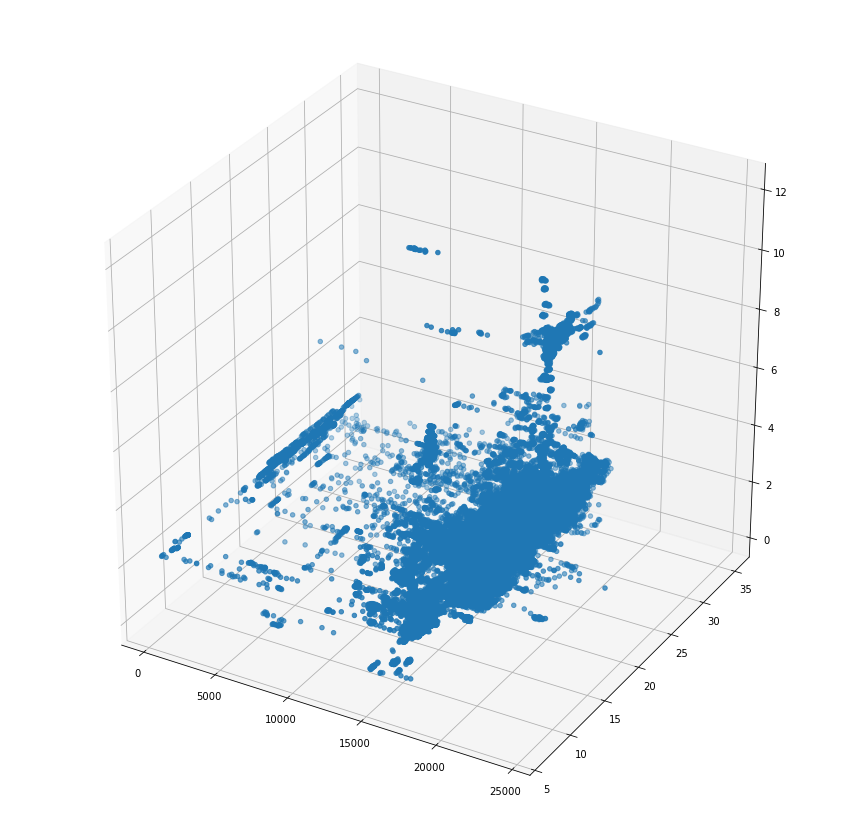

In [24]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=df['value'], ys=df['value_energy'], zs=df['value_qual'])

Cluster points to detect anomalies

In [25]:
from sklearn.cluster import KMeans

df_for_clusters = df[['value', 'value_energy', 'value_qual']]

y_pred = KMeans(n_clusters = 3).fit_predict(df_for_clusters)

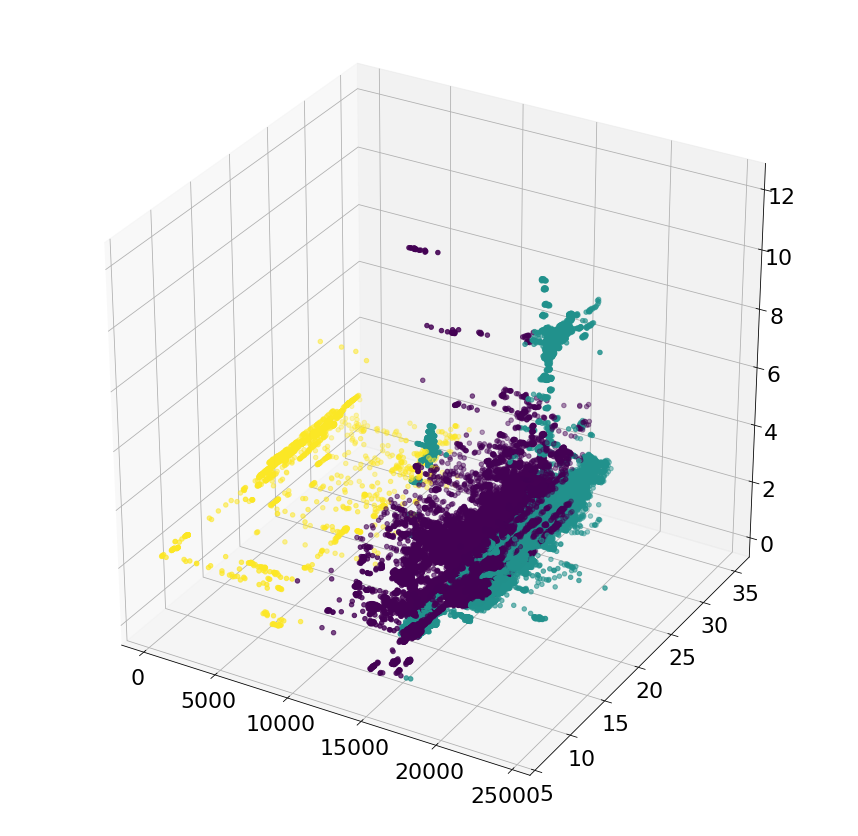

In [71]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=df['value'], ys=df['value_energy'], zs=df['value_qual'], c = y_pred)

Look at separate clusters 

In [28]:
test = pd.DataFrame(df_for_clusters)
test['pred'] = y_pred

CLuster number 0:

In [29]:
test_0 = test.loc[(test['pred'] == 0) & (test['value'] <=18100.) & (test['value_qual']>=1.) & (test['value_qual'] <= 2.5) & (test['value_energy']>=15.)]

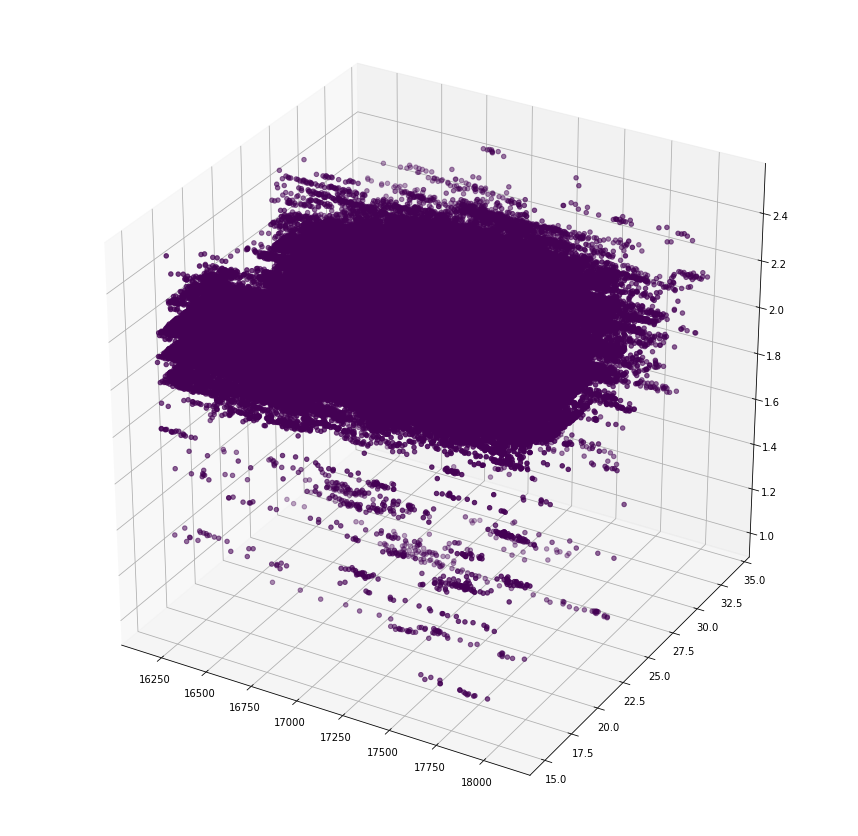

In [30]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=test_0['value'], ys=test_0['value_energy'], zs=test_0['value_qual'], c = test_0['pred'])

first:

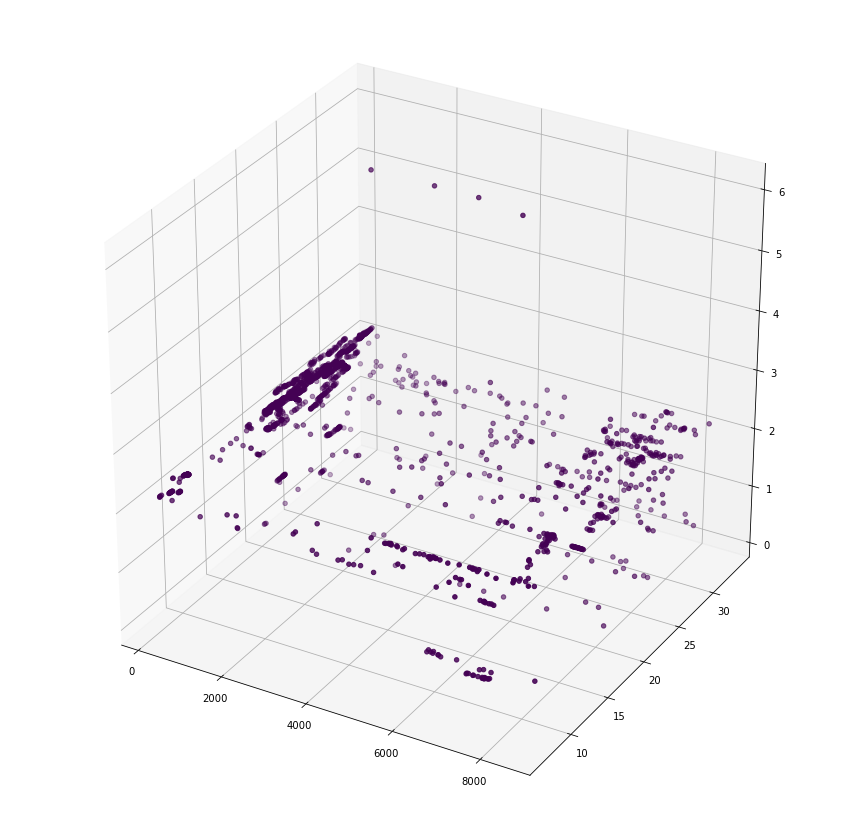

In [29]:
test_1 = test.loc[test['pred'] == 1]
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=test_1['value'], ys=test_1['value_energy'], zs=test_1['value_qual'], c = test_1['pred'])

second:

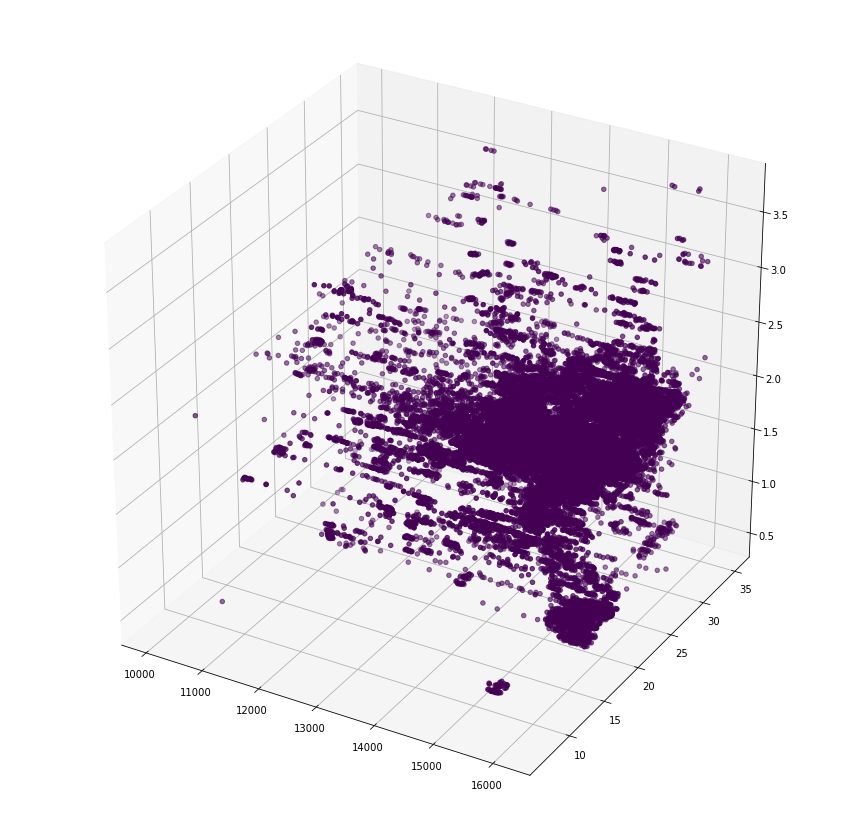

In [32]:
test_2 = test.loc[(test['pred'] == 2) & (test['value'] >=10000.) & (test['value_qual'] <= 4.) & (test['value_qual'] >=0.5)]
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=test_2['value'], ys=test_2['value_energy'], zs=test_2['value_qual'], c = test_2['pred'])

In [86]:
def target_anom(cluster, value, value_qual, value_energy):
    """функция для разметки аномалий"""
    if  (cluster == 2):
        #if (value <=10000.) & ((value_qual >= 4.) | (value_qual <=0.5)):
        return 1
        #else:
         #   return 0
    elif (cluster == 1):
        return 0
    elif (cluster == 0):
        #if (value >=18100.) & ((value_qual<=1.) | (value_qual >= 2.5)) & (value_energy <= 15.):
        return 0
        #else:
         #   return 1
    

In [87]:
df_clust = df
df_clust['cluster'] = y_pred
df_clust['anom'] = df_clust.apply(lambda row: target_anom(row['cluster'], row['value'], row['value_qual'], row['value_energy']), axis=1)

In [88]:
df_clust.groupby('anom')['anom'].count()

anom
0    489924
1      2099
Name: anom, dtype: int64

# let's try out XGBoost

In [89]:
train_size = int(df_clust.shape[0] * 0.7)
train = df_clust[:train_size]
test = df_clust[train_size:]

In [98]:
X_train = train.drop(['anom', 'timestamp', 'day', 'M', 'W', 'diff', 'cluster'], axis = 1)
X_test = test.drop(['anom', 'timestamp', 'day', 'M', 'W', 'diff', 'cluster'], axis = 1)
y_train = train['anom'].values.astype(int)
y_test = test['anom'].values.astype(int)

In [99]:
model = XGBClassifier()
model_fit = model.fit(X_train, y_train)
preds_validation = model_fit.predict(X_test)

In [100]:
print('R^2:', (1 - ((preds_validation-y_test)**2).sum()/(((y_test-y_test.mean())**2).sum())))

R^2: 1.0


In [101]:
preds = pd.DataFrame(data = X_test) 
preds['anom'] = preds_validation
preds.head(2)

,value,mean_value,mean_W_value,mean_M_value,diff_mean_week_M,diff_mean_week_day,value_qual,mean_value_qual,value_energy,mean_value_energy,anom
344416,17815.1025,17999.50638,17316.969004,17168.089659,148.879345,-682.537375,2.4,2.247692,18.452698,17.649357,0
344417,17780.7625,17999.50638,17316.969004,17168.089659,148.879345,-682.537375,2.4,2.247692,18.542128,17.649357,0


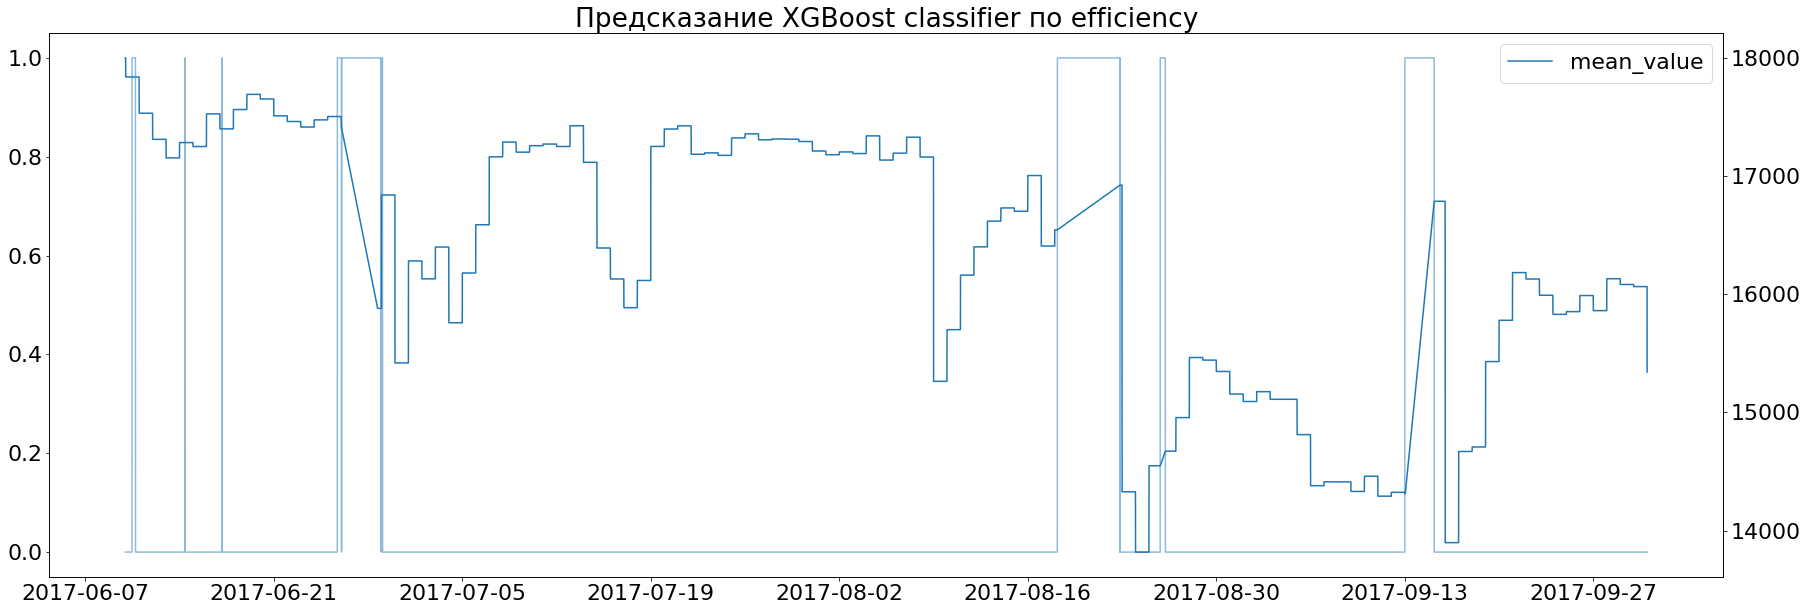

In [94]:
fig, ax = plt.subplots(1, figsize=(30,10))

matplotlib.rcParams.update({'font.size': 22})

ax.plot(df_clust['timestamp'].iloc[train_size:], preds['anom'], alpha=0.5, label='anom.')
ax2 = ax.twinx()
ax2.plot(df_clust['timestamp'].iloc[train_size:], preds['mean_value'])
plt.xlabel('timestamp')
plt.legend()
plt.title('Предсказание XGBoost classifier по efficiency')

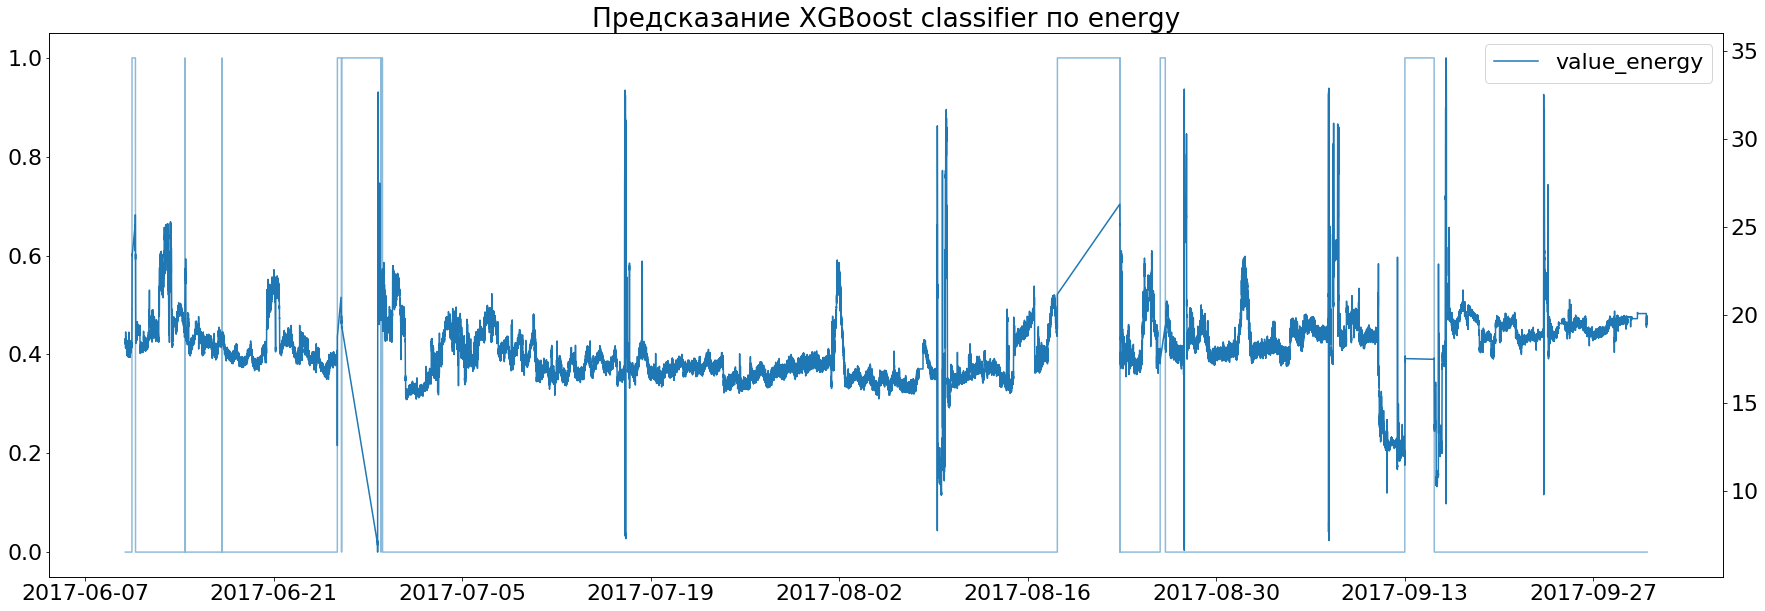

In [102]:
fig, ax = plt.subplots(1, figsize=(30,10))

matplotlib.rcParams.update({'font.size': 22})

ax.plot(df_clust['timestamp'].iloc[train_size:], preds['anom'], alpha=0.5, label='anom.')

ax2 = ax.twinx()
ax2.plot(df_clust['timestamp'].iloc[train_size:], preds['value_energy'])
plt.xlabel('timestamp')
plt.legend()
plt.title('Предсказание XGBoost classifier по energy')

аномалии по эффективности на трейне:

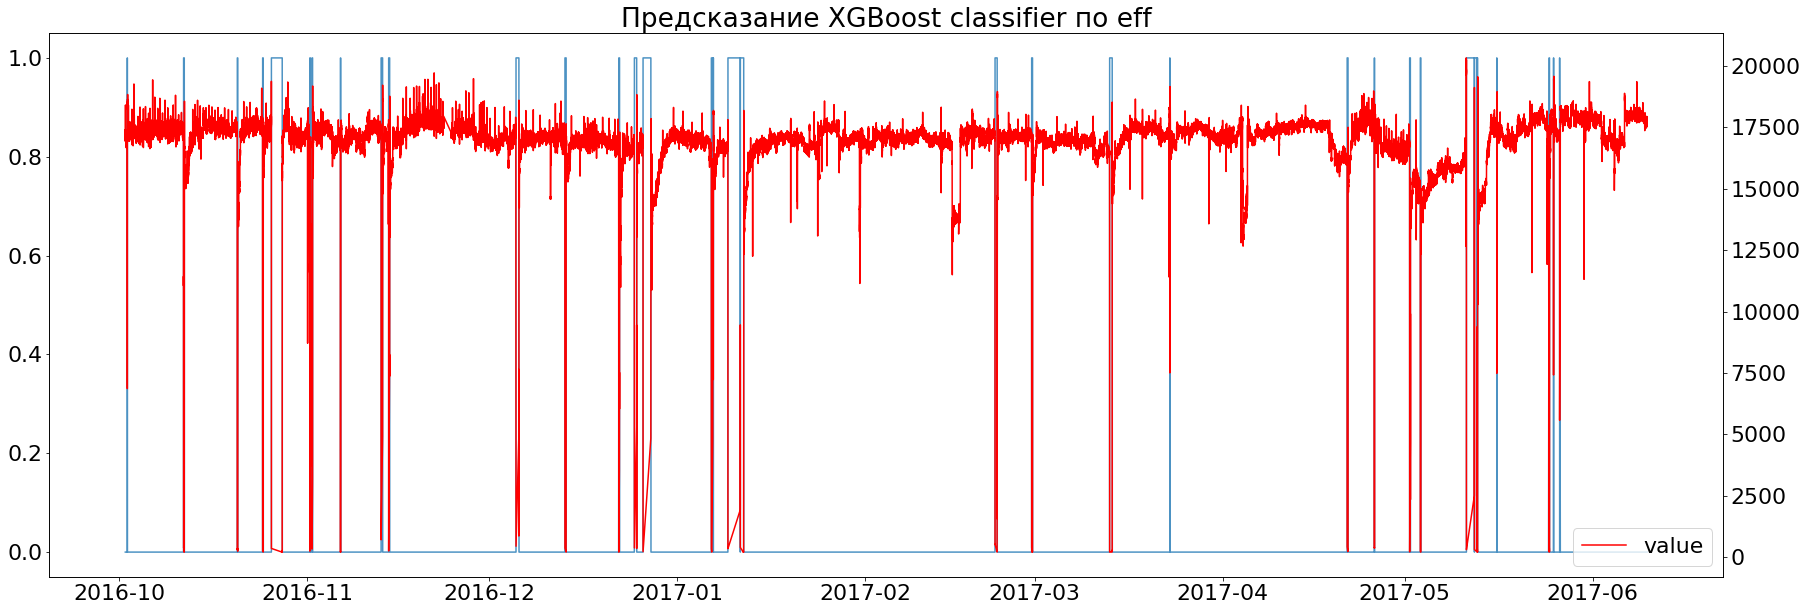

In [107]:
fig, ax = plt.subplots(1, figsize=(30,10))

matplotlib.rcParams.update({'font.size': 22})

ax.plot(df_clust['timestamp'].iloc[:train_size], df_clust['anom'][:train_size], alpha=0.8, label='anom.')

ax2 = ax.twinx()
ax2.plot(df_clust['timestamp'].iloc[:train_size], df_clust['value'][:train_size], color='r')
plt.xlabel('timestamp')
plt.legend()
plt.title('Предсказание XGBoost classifier по eff')

на тесте:

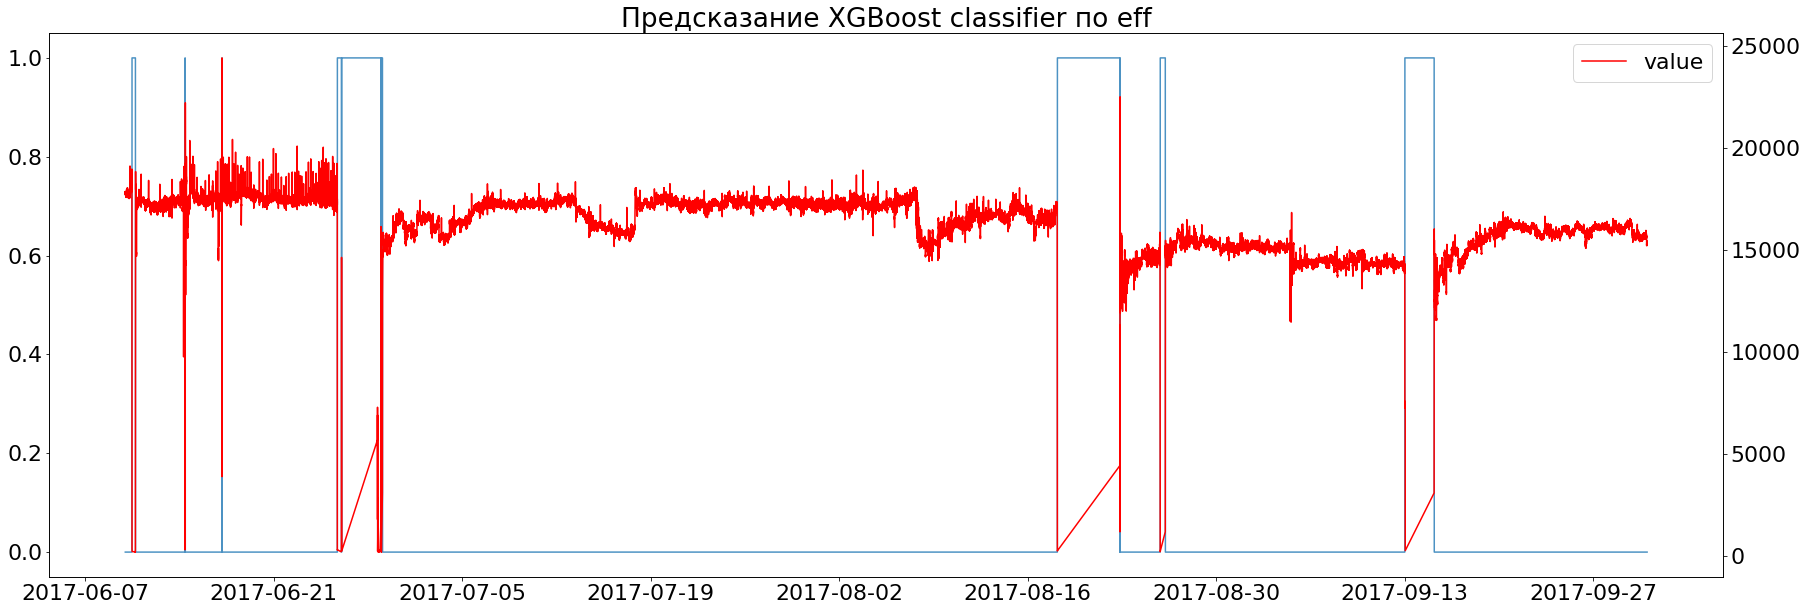

In [109]:
fig, ax = plt.subplots(1, figsize=(30,10))

matplotlib.rcParams.update({'font.size': 22})

ax.plot(df_clust['timestamp'].iloc[train_size:], preds['anom'], alpha=0.8, label='anom.')

ax2 = ax.twinx()
ax2.plot(df_clust['timestamp'].iloc[train_size:], preds['value'], color='r')
plt.xlabel('timestamp')
plt.legend()
plt.title('Предсказание XGBoost classifier по eff')